In [1]:
from preparing_data import augment_data


In [2]:
augment_data('./masses_train/','train3')

In [3]:
a0 = !ls './augmented_data/train2/0'
a1 = !ls './augmented_data/train2/1'
print(len(a0)+len(a1))

5064


In [1]:
# from skimage import io
from pathlib import Path
import numpy as np
from matplotlib import image as img
from random import sample

import tensorflow.keras as keras
from PIL import Image
def my_load_img(fname):
    img = Image.open(fname)
    rbg_img = img.convert('RGB')
    array = keras.preprocessing.image.img_to_array(rbg_img) 
    return array

def rgbt2gray(rgb):
    return np.dot(rgb[...,:3],[0.2989,0.5870,0.1140])

def load_data(data_path='augmented_data/train_set',size=4398, img_size=(256,256,3),cmap='rgb'):
    '''
        Load from data_path size random images 
    '''
    
    X = np.zeros(shape=(size,img_size[0],img_size[1],img_size[2]))
    y = np.zeros(shape=(size))
    last_index= 0  
    sample_0_size = size - int(size/2)
    sample_1_size = size - sample_0_size
    
    
    negatives_path = data_path+'/0/'
    positives_path = data_path+'/1/'
    
    pn = Path(negatives_path)
    pp = Path(positives_path)
    p_list = list(pp.iterdir())
    n_list = list(pn.iterdir())
    p_len = len(p_list)
    n_len = len(n_list)
    
    assert p_len+n_len >= size
    if n_len<sample_0_size:
        sample_1_size += sample_0_size - n_len
        sample_0_size = n_len
    n_list = sample(n_list,sample_0_size)
    
    if p_len<sample_1_size:
        sample_0_size+=sample_1_size-p_len
        sample_1_size = p_len
    p_list = sample(p_list,sample_1_size)
    
    for l,current_class in [(n_list,0),(p_list,1)]:
        for j in l:
            if j.is_file():
                if cmap == 'gray':
                    X[last_index] = rgbt2gray(img.imread(str(j)))
                elif cmap == 'rgb':
                    X[last_index] = my_load_img(str(j))
                y[last_index] = current_class
                last_index += 1

    return X,y
    

In [3]:
import pickle
from matplotlib import pyplot as plt

def train_model(model,callbacks,X_train,y_train,X_val,y_val,history_file_name='histories_learning_curves.pickle'):
    
    print('Training model with size ',(len(y_train),len(y_val)),' ...')
    history = model.fit(X_train,
                        y_train,
                        batch_size=20,
                        epochs=30,
                        validation_data=(X_val, y_val),shuffle=True, callbacks=callbacks)
    print('Trained model')
     
    with open(history_file_name,'rb') as file:
        histories = pickle.load(file)
    with open(history_file_name,'wb') as file:
        size = len(y_train)
        histories.append((size,history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss']))
        pickle.dump(histories,file)


In [4]:
#todo: configure data path and validation path
import multiprocessing as mp

def learning_curves(model_init,train_path='augmented_data/train_set',validation_path='augmented_data/validation_set', validation_size=600,sequence_of_data_sizes=[600,900,1200,1500,1800,2100,2400,2700,3200,3500,3800,4000],history_file_name='histories_learning_curves.pickle'):
    def _train_(model_init,size,history_file_name):
            model,callbacks = model_init()
            X_train,y_train = load_data(train_path,size=size)
            X_val,y_val = load_data(validation_path,size=validation_size)
            train_model(model,callbacks,X_train,y_train,X_val,y_val,history_file_name)
            del model
    histories = []
    
    with open(history_file_name,'wb') as file:
        pickle.dump(histories,file)
        
    for size in sequence_of_data_sizes:
        
        p = mp.Process(target=_train_,args=(model_init,size,history_file_name,))
        p.start()
        p.join()
    

In [5]:
def init_model():
    BATCH_SIZE = 8
    keras.preprocessing.image.load_img = my_load_img
    from tensorflow.keras.models import load_model
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.optimizers import RMSprop, SGD,Adam
    from tensorflow.keras.regularizers import l2,l1,l1_l2
    from tensorflow.keras.applications.resnet50 import ResNet50
    from tensorflow.keras.applications.vgg16 import VGG16
    conv_base = VGG16(weights='imagenet',
    include_top=False, input_shape=(256, 256, 3))
    # esto es para congelarlas todas menos una especifica
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    # esto es para entrenar solamente el clasificador
    # conv_base.trainable = False

    # pretrainded model
    from tensorflow.keras import models
    from tensorflow.keras import layers
    model = models.Sequential()
    model.add(conv_base)
    # model.add(layers.Conv2D(64,(1,1)))
    # model.add(layers.Conv2D(64,(1,1)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))

    print(model.summary())

    model.compile(loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-5),
    metrics=['accuracy'])


    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0,mode='min')
    mcp_save = ModelCheckpoint('.{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5',save_best_only=True,monitor='val_loss',mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=7, min_delta=1e-4, mode='min')
    board = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE,
                        write_graph=True, 
                        write_images=True,
    #                     update_freq='epoch'
                       )
    callbacks=[earlyStopping,reduce_lr_loss,board]
    return model,callbacks

In [21]:
def plot_learning_curves(pickle_history_file_path='histories_learning_curves.pickle',sequence_of_data_sizes=[600,900,1200,1500,1800,2100,2400,2700,3200,3500],metric='loss'):
    with open(pickle_history_file_path,'rb') as file:
        histories = pickle.load(file)
    print(len(histories[0]))
    if metric == 'loss':
        plt.plot(sequence_of_data_sizes,[min(x) for _,_,_,x,_ in histories],'b',label='training error')
        plt.plot(sequence_of_data_sizes,[min(y) for _,_,_,_,y in histories],'r',label='validation error')
        plt.title('Training and validation loss')
    elif metric == 'acc':
        plt.plot(sequence_of_data_sizes,[min(x) for _,x,_,_,_ in histories],'b',label='training acc')
        plt.plot(sequence_of_data_sizes,[min(y) for _,_,y,_,_ in histories],'r',label='validation acc')
        plt.title('Training and validation acc')
        
    plt.legend()
    plt.show()

In [3]:
history_file_name='history_learning_curves_with_loss_funct.pickle'

In [15]:
learning_curves(init_model,history_file_name=history_file_name,sequence_of_data_sizes=[2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500])

NameError: name 'learning_curves' is not defined

5


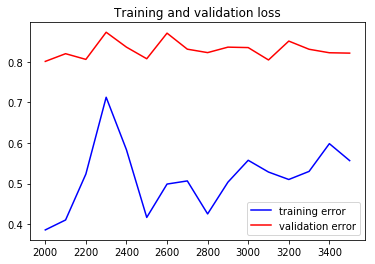

In [22]:
plot_learning_curves(history_file_name,sequence_of_data_sizes=[2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500])

5


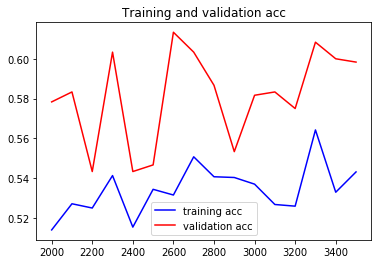

In [23]:
import pickle
from matplotlib import pyplot as plt
plot_learning_curves(history_file_name,sequence_of_data_sizes=[2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500],metric='acc')